<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:09:57] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


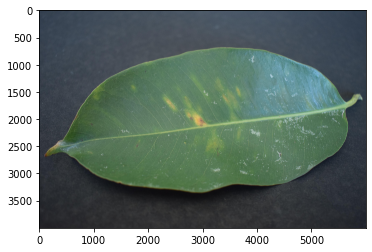

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

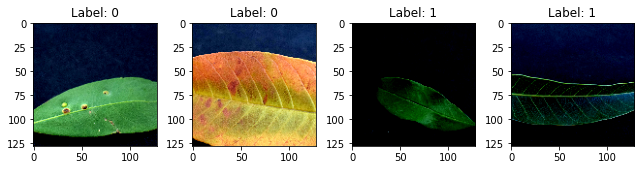

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:10:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:10:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2520865477171153 samples/sec                   batch loss = 0.4798881411552429 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.266081144063192 samples/sec                   batch loss = 0.4132598638534546 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.264816451313147 samples/sec                   batch loss = 1.4583431482315063 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.266683357246767 samples/sec                   batch loss = 0.6497295498847961 | accuracy = 0.4625


Epoch[1] Batch[25] Speed: 1.2653294686363428 samples/sec                   batch loss = 0.6866054534912109 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2663515911955392 samples/sec                   batch loss = 2.534038543701172 | accuracy = 0.5333333333333333


Epoch[1] Batch[35] Speed: 1.261121756253868 samples/sec                   batch loss = 0.36069467663764954 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2705890407369367 samples/sec                   batch loss = 0.6199699640274048 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.2673578463488333 samples/sec                   batch loss = 0.9174916744232178 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2653890200914972 samples/sec                   batch loss = 0.10489273816347122 | accuracy = 0.62


Epoch[1] Batch[55] Speed: 1.270554400490373 samples/sec                   batch loss = 1.6896661520004272 | accuracy = 0.6318181818181818


Epoch[1] Batch[60] Speed: 1.2694574748949232 samples/sec                   batch loss = 0.43866604566574097 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.2718114138014134 samples/sec                   batch loss = 0.4412936568260193 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2707471589581447 samples/sec                   batch loss = 0.7159585952758789 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2759259964844611 samples/sec                   batch loss = 0.8393605947494507 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.2737044568453426 samples/sec                   batch loss = 0.4907669126987457 | accuracy = 0.596875


Epoch[1] Batch[85] Speed: 1.269639139405067 samples/sec                   batch loss = 0.43847960233688354 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2680836590359907 samples/sec                   batch loss = 0.4744325578212738 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.2661213693435338 samples/sec                   batch loss = 0.15750719606876373 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2691025577794675 samples/sec                   batch loss = 1.5545814037322998 | accuracy = 0.615


Epoch[1] Batch[105] Speed: 1.2684698460088208 samples/sec                   batch loss = 0.5346386432647705 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.266880013048462 samples/sec                   batch loss = 0.6463913917541504 | accuracy = 0.625


Epoch[1] Batch[115] Speed: 1.2732620238875665 samples/sec                   batch loss = 0.3075397312641144 | accuracy = 0.6326086956521739


Epoch[1] Batch[120] Speed: 1.2731180602413772 samples/sec                   batch loss = 0.8154580593109131 | accuracy = 0.63125


Epoch[1] Batch[125] Speed: 1.265421279470239 samples/sec                   batch loss = 0.9233803153038025 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.2688970539686122 samples/sec                   batch loss = 0.9560070037841797 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2726925433784808 samples/sec                   batch loss = 0.2753938138484955 | accuracy = 0.6351851851851852


Epoch[1] Batch[140] Speed: 1.2694175176000124 samples/sec                   batch loss = 0.7286556959152222 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.2724051955813365 samples/sec                   batch loss = 0.23034504055976868 | accuracy = 0.6362068965517241


Epoch[1] Batch[150] Speed: 1.2759689847016507 samples/sec                   batch loss = 0.6835993528366089 | accuracy = 0.64


Epoch[1] Batch[155] Speed: 1.2680801127282026 samples/sec                   batch loss = 0.7662930488586426 | accuracy = 0.6483870967741936


Epoch[1] Batch[160] Speed: 1.2734924334558102 samples/sec                   batch loss = 1.7674695253372192 | accuracy = 0.65


Epoch[1] Batch[165] Speed: 1.2735757648264112 samples/sec                   batch loss = 0.37464630603790283 | accuracy = 0.6530303030303031


Epoch[1] Batch[170] Speed: 1.2693766984419106 samples/sec                   batch loss = 0.3899775743484497 | accuracy = 0.6529411764705882


Epoch[1] Batch[175] Speed: 1.2652644837810747 samples/sec                   batch loss = 0.7418208122253418 | accuracy = 0.65


Epoch[1] Batch[180] Speed: 1.2657042398773255 samples/sec                   batch loss = 0.37447914481163025 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.271147875622316 samples/sec                   batch loss = 0.46773236989974976 | accuracy = 0.6486486486486487


Epoch[1] Batch[190] Speed: 1.2716039716705108 samples/sec                   batch loss = 0.538245439529419 | accuracy = 0.6486842105263158


Epoch[1] Batch[195] Speed: 1.2677724262556165 samples/sec                   batch loss = 0.4085420072078705 | accuracy = 0.6538461538461539


Epoch[1] Batch[200] Speed: 1.2671119463924216 samples/sec                   batch loss = 0.3757888674736023 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.2654836077215759 samples/sec                   batch loss = 0.5959491729736328 | accuracy = 0.6585365853658537


Epoch[1] Batch[210] Speed: 1.2673544955719083 samples/sec                   batch loss = 0.1464562863111496 | accuracy = 0.6630952380952381


Epoch[1] Batch[215] Speed: 1.266586008439973 samples/sec                   batch loss = 0.4384134113788605 | accuracy = 0.6651162790697674


Epoch[1] Batch[220] Speed: 1.2714683804276572 samples/sec                   batch loss = 0.5612810254096985 | accuracy = 0.6590909090909091


Epoch[1] Batch[225] Speed: 1.265079490035582 samples/sec                   batch loss = 0.6499950885772705 | accuracy = 0.6588888888888889


Epoch[1] Batch[230] Speed: 1.274323624814241 samples/sec                   batch loss = 0.692283570766449 | accuracy = 0.6597826086956522


Epoch[1] Batch[235] Speed: 1.2700944416652837 samples/sec                   batch loss = 0.7055718302726746 | accuracy = 0.6563829787234042


Epoch[1] Batch[240] Speed: 1.2702995640816879 samples/sec                   batch loss = 1.1722378730773926 | accuracy = 0.653125


Epoch[1] Batch[245] Speed: 1.2740776269852196 samples/sec                   batch loss = 0.532137393951416 | accuracy = 0.6520408163265307


Epoch[1] Batch[250] Speed: 1.270218968939507 samples/sec                   batch loss = 0.5418639183044434 | accuracy = 0.652


Epoch[1] Batch[255] Speed: 1.2730105435359524 samples/sec                   batch loss = 0.31953129172325134 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.2694399932688842 samples/sec                   batch loss = 0.42852655053138733 | accuracy = 0.6596153846153846


Epoch[1] Batch[265] Speed: 1.2660170373198183 samples/sec                   batch loss = 0.4733784794807434 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.2653367213984186 samples/sec                   batch loss = 1.0237665176391602 | accuracy = 0.6583333333333333


Epoch[1] Batch[275] Speed: 1.2633545671859605 samples/sec                   batch loss = 0.5021618604660034 | accuracy = 0.6581818181818182


Epoch[1] Batch[280] Speed: 1.262104332715216 samples/sec                   batch loss = 0.8265205025672913 | accuracy = 0.6598214285714286


Epoch[1] Batch[285] Speed: 1.2655058488442612 samples/sec                   batch loss = 0.46489188075065613 | accuracy = 0.6596491228070176


Epoch[1] Batch[290] Speed: 1.262783077253676 samples/sec                   batch loss = 0.4219585359096527 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2656799866259247 samples/sec                   batch loss = 0.24538199603557587 | accuracy = 0.661864406779661


Epoch[1] Batch[300] Speed: 1.265033893906215 samples/sec                   batch loss = 1.6620004177093506 | accuracy = 0.6591666666666667


Epoch[1] Batch[305] Speed: 1.2639424764033709 samples/sec                   batch loss = 1.0335042476654053 | accuracy = 0.6581967213114754


Epoch[1] Batch[310] Speed: 1.2599337441238707 samples/sec                   batch loss = 0.3949231505393982 | accuracy = 0.6580645161290323


Epoch[1] Batch[315] Speed: 1.2683821950675183 samples/sec                   batch loss = 0.6857051849365234 | accuracy = 0.6611111111111111


Epoch[1] Batch[320] Speed: 1.2672378038523624 samples/sec                   batch loss = 0.38550880551338196 | accuracy = 0.66328125


Epoch[1] Batch[325] Speed: 1.266682018360122 samples/sec                   batch loss = 0.3143216371536255 | accuracy = 0.6646153846153846


Epoch[1] Batch[330] Speed: 1.2725516041589457 samples/sec                   batch loss = 0.50387042760849 | accuracy = 0.6659090909090909


Epoch[1] Batch[335] Speed: 1.2691098538602168 samples/sec                   batch loss = 0.7376681566238403 | accuracy = 0.6649253731343283


Epoch[1] Batch[340] Speed: 1.270068193085731 samples/sec                   batch loss = 0.48914018273353577 | accuracy = 0.6661764705882353


Epoch[1] Batch[345] Speed: 1.272564924475378 samples/sec                   batch loss = 0.31297144293785095 | accuracy = 0.6673913043478261


Epoch[1] Batch[350] Speed: 1.273100381044958 samples/sec                   batch loss = 0.29414016008377075 | accuracy = 0.6692857142857143


Epoch[1] Batch[355] Speed: 1.2737539681400858 samples/sec                   batch loss = 0.13774244487285614 | accuracy = 0.6711267605633803


Epoch[1] Batch[360] Speed: 1.2728246298295514 samples/sec                   batch loss = 1.0950952768325806 | accuracy = 0.6715277777777777


Epoch[1] Batch[365] Speed: 1.2724970709886767 samples/sec                   batch loss = 0.40120288729667664 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.2760660342170227 samples/sec                   batch loss = 0.9807490706443787 | accuracy = 0.6702702702702703


Epoch[1] Batch[375] Speed: 1.2753953355355672 samples/sec                   batch loss = 0.5819879174232483 | accuracy = 0.6713333333333333


Epoch[1] Batch[380] Speed: 1.268164462720398 samples/sec                   batch loss = 0.5611623525619507 | accuracy = 0.6710526315789473


Epoch[1] Batch[385] Speed: 1.270117133619417 samples/sec                   batch loss = 0.21485739946365356 | accuracy = 0.6701298701298701


Epoch[1] Batch[390] Speed: 1.2709805105447145 samples/sec                   batch loss = 0.544310450553894 | accuracy = 0.6711538461538461


Epoch[1] Batch[395] Speed: 1.27621241280684 samples/sec                   batch loss = 0.25362396240234375 | accuracy = 0.6721518987341772


Epoch[1] Batch[400] Speed: 1.269312929764555 samples/sec                   batch loss = 0.3000066578388214 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.274861628344436 samples/sec                   batch loss = 0.3364405632019043 | accuracy = 0.6759259259259259


Epoch[1] Batch[410] Speed: 1.2766102701391866 samples/sec                   batch loss = 0.4651753604412079 | accuracy = 0.6780487804878049


Epoch[1] Batch[415] Speed: 1.2727783771415981 samples/sec                   batch loss = 1.1611502170562744 | accuracy = 0.6765060240963855


Epoch[1] Batch[420] Speed: 1.2718471832021603 samples/sec                   batch loss = 0.7487433552742004 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.2685760215224908 samples/sec                   batch loss = 0.2845805287361145 | accuracy = 0.6770588235294117


Epoch[1] Batch[430] Speed: 1.2716271031279562 samples/sec                   batch loss = 0.9573061466217041 | accuracy = 0.6761627906976744


Epoch[1] Batch[435] Speed: 1.272969203221981 samples/sec                   batch loss = 0.5819970369338989 | accuracy = 0.6770114942528735


Epoch[1] Batch[440] Speed: 1.2767828135693546 samples/sec                   batch loss = 0.14448896050453186 | accuracy = 0.678409090909091


Epoch[1] Batch[445] Speed: 1.27443455813043 samples/sec                   batch loss = 0.5454213619232178 | accuracy = 0.6775280898876405


Epoch[1] Batch[450] Speed: 1.2735589429984007 samples/sec                   batch loss = 0.19601508975028992 | accuracy = 0.6772222222222222


Epoch[1] Batch[455] Speed: 1.2808583877623065 samples/sec                   batch loss = 0.48929110169410706 | accuracy = 0.6780219780219781


Epoch[1] Batch[460] Speed: 1.2668781954244517 samples/sec                   batch loss = 0.3784220814704895 | accuracy = 0.6766304347826086


Epoch[1] Batch[465] Speed: 1.2708335006092377 samples/sec                   batch loss = 0.6626294255256653 | accuracy = 0.6768817204301075


Epoch[1] Batch[470] Speed: 1.2743675699087234 samples/sec                   batch loss = 0.3632975220680237 | accuracy = 0.6787234042553192


Epoch[1] Batch[475] Speed: 1.2708741247087412 samples/sec                   batch loss = 0.1294652819633484 | accuracy = 0.6805263157894736


Epoch[1] Batch[480] Speed: 1.2740754983862956 samples/sec                   batch loss = 0.557160496711731 | accuracy = 0.68125


Epoch[1] Batch[485] Speed: 1.2740779172492604 samples/sec                   batch loss = 0.3134280741214752 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.2730340159840083 samples/sec                   batch loss = 1.039307713508606 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.2715524108253593 samples/sec                   batch loss = 0.535426139831543 | accuracy = 0.6818181818181818


Epoch[1] Batch[500] Speed: 1.2729487272383773 samples/sec                   batch loss = 0.9140037894248962 | accuracy = 0.6825


Epoch[1] Batch[505] Speed: 1.2729344330742303 samples/sec                   batch loss = 0.747779905796051 | accuracy = 0.6816831683168317


Epoch[1] Batch[510] Speed: 1.2769624015260939 samples/sec                   batch loss = 0.5087860822677612 | accuracy = 0.6823529411764706


Epoch[1] Batch[515] Speed: 1.272699204977186 samples/sec                   batch loss = 0.7509548664093018 | accuracy = 0.6815533980582524


Epoch[1] Batch[520] Speed: 1.2728092762681291 samples/sec                   batch loss = 0.3546479642391205 | accuracy = 0.6836538461538462


Epoch[1] Batch[525] Speed: 1.271721950902629 samples/sec                   batch loss = 0.5812867879867554 | accuracy = 0.6838095238095238


Epoch[1] Batch[530] Speed: 1.2772099036277333 samples/sec                   batch loss = 1.4770163297653198 | accuracy = 0.685377358490566


Epoch[1] Batch[535] Speed: 1.2740815939385572 samples/sec                   batch loss = 0.40429505705833435 | accuracy = 0.685981308411215


Epoch[1] Batch[540] Speed: 1.2743985462457457 samples/sec                   batch loss = 0.40545499324798584 | accuracy = 0.6875


Epoch[1] Batch[545] Speed: 1.2778387141072811 samples/sec                   batch loss = 0.33804595470428467 | accuracy = 0.6880733944954128


Epoch[1] Batch[550] Speed: 1.2814699478657656 samples/sec                   batch loss = 0.370022177696228 | accuracy = 0.6881818181818182


Epoch[1] Batch[555] Speed: 1.277055325081639 samples/sec                   batch loss = 0.5305428504943848 | accuracy = 0.6887387387387387


Epoch[1] Batch[560] Speed: 1.272915020568045 samples/sec                   batch loss = 0.3855901062488556 | accuracy = 0.6892857142857143


Epoch[1] Batch[565] Speed: 1.2685154983424147 samples/sec                   batch loss = 0.8654817938804626 | accuracy = 0.6884955752212389


Epoch[1] Batch[570] Speed: 1.272136883411676 samples/sec                   batch loss = 0.4207797348499298 | accuracy = 0.6894736842105263


Epoch[1] Batch[575] Speed: 1.2722413582997911 samples/sec                   batch loss = 0.3199710249900818 | accuracy = 0.6908695652173913


Epoch[1] Batch[580] Speed: 1.2762938674249222 samples/sec                   batch loss = 0.3184184432029724 | accuracy = 0.6913793103448276


Epoch[1] Batch[585] Speed: 1.2708367735447565 samples/sec                   batch loss = 0.8283467292785645 | accuracy = 0.6914529914529914


Epoch[1] Batch[590] Speed: 1.2678826051194683 samples/sec                   batch loss = 0.8747432827949524 | accuracy = 0.690677966101695


Epoch[1] Batch[595] Speed: 1.2680854801206711 samples/sec                   batch loss = 0.5751394033432007 | accuracy = 0.6915966386554622


Epoch[1] Batch[600] Speed: 1.2670877348589042 samples/sec                   batch loss = 0.15501856803894043 | accuracy = 0.69125


Epoch[1] Batch[605] Speed: 1.2688567480914263 samples/sec                   batch loss = 1.4561026096343994 | accuracy = 0.6921487603305785


Epoch[1] Batch[610] Speed: 1.2708349445493003 samples/sec                   batch loss = 0.2735995948314667 | accuracy = 0.6930327868852459


Epoch[1] Batch[615] Speed: 1.2721402595247973 samples/sec                   batch loss = 0.9871571063995361 | accuracy = 0.6926829268292682


Epoch[1] Batch[620] Speed: 1.2684016613526838 samples/sec                   batch loss = 0.6608734130859375 | accuracy = 0.6907258064516129


Epoch[1] Batch[625] Speed: 1.2676279772478176 samples/sec                   batch loss = 0.4038827121257782 | accuracy = 0.6916


Epoch[1] Batch[630] Speed: 1.2772306141621028 samples/sec                   batch loss = 0.21429334580898285 | accuracy = 0.6924603174603174


Epoch[1] Batch[635] Speed: 1.270161654512453 samples/sec                   batch loss = 0.2012392282485962 | accuracy = 0.6925196850393701


Epoch[1] Batch[640] Speed: 1.2695704447018648 samples/sec                   batch loss = 0.7590588927268982 | accuracy = 0.6921875


Epoch[1] Batch[645] Speed: 1.2693224370374394 samples/sec                   batch loss = 0.337262898683548 | accuracy = 0.6926356589147287


Epoch[1] Batch[650] Speed: 1.2765711240392361 samples/sec                   batch loss = 0.4620639979839325 | accuracy = 0.6923076923076923


Epoch[1] Batch[655] Speed: 1.2741920012576948 samples/sec                   batch loss = 1.185681700706482 | accuracy = 0.6931297709923664


Epoch[1] Batch[660] Speed: 1.2746818559803554 samples/sec                   batch loss = 0.5944363474845886 | accuracy = 0.6931818181818182


Epoch[1] Batch[665] Speed: 1.2730154697804419 samples/sec                   batch loss = 0.28447356820106506 | accuracy = 0.6947368421052632


Epoch[1] Batch[670] Speed: 1.2717707297589838 samples/sec                   batch loss = 0.55439692735672 | accuracy = 0.6940298507462687


Epoch[1] Batch[675] Speed: 1.2777302040046659 samples/sec                   batch loss = 1.061909556388855 | accuracy = 0.6948148148148148


Epoch[1] Batch[680] Speed: 1.275216284979541 samples/sec                   batch loss = 0.5525285005569458 | accuracy = 0.6941176470588235


Epoch[1] Batch[685] Speed: 1.276514206202058 samples/sec                   batch loss = 0.7184045314788818 | accuracy = 0.6941605839416058


Epoch[1] Batch[690] Speed: 1.272380877841253 samples/sec                   batch loss = 0.5705155730247498 | accuracy = 0.6942028985507246


Epoch[1] Batch[695] Speed: 1.2731976710124466 samples/sec                   batch loss = 0.31298014521598816 | accuracy = 0.6946043165467626


Epoch[1] Batch[700] Speed: 1.2786400207116133 samples/sec                   batch loss = 0.6264208555221558 | accuracy = 0.6942857142857143


Epoch[1] Batch[705] Speed: 1.2708677710052565 samples/sec                   batch loss = 0.2946610748767853 | accuracy = 0.6946808510638298


Epoch[1] Batch[710] Speed: 1.276388927139573 samples/sec                   batch loss = 0.6062139272689819 | accuracy = 0.6950704225352112


Epoch[1] Batch[715] Speed: 1.279628135408953 samples/sec                   batch loss = 1.0293611288070679 | accuracy = 0.6951048951048951


Epoch[1] Batch[720] Speed: 1.2744831580400302 samples/sec                   batch loss = 0.426859974861145 | accuracy = 0.6958333333333333


Epoch[1] Batch[725] Speed: 1.2838304716686666 samples/sec                   batch loss = 0.3009217083454132 | accuracy = 0.696551724137931


Epoch[1] Batch[730] Speed: 1.2781787668876348 samples/sec                   batch loss = 0.6533051133155823 | accuracy = 0.696917808219178


Epoch[1] Batch[735] Speed: 1.2790085809949563 samples/sec                   batch loss = 0.4790705144405365 | accuracy = 0.6969387755102041


Epoch[1] Batch[740] Speed: 1.2729691066356066 samples/sec                   batch loss = 0.4465164542198181 | accuracy = 0.6962837837837837


Epoch[1] Batch[745] Speed: 1.2774581825712998 samples/sec                   batch loss = 0.39692047238349915 | accuracy = 0.696979865771812


Epoch[1] Batch[750] Speed: 1.2769498637135968 samples/sec                   batch loss = 0.3128757178783417 | accuracy = 0.6973333333333334


Epoch[1] Batch[755] Speed: 1.2745447361569868 samples/sec                   batch loss = 0.46471142768859863 | accuracy = 0.6973509933774834


Epoch[1] Batch[760] Speed: 1.2792045961411629 samples/sec                   batch loss = 0.2969258427619934 | accuracy = 0.6980263157894737


Epoch[1] Batch[765] Speed: 1.2793030164458892 samples/sec                   batch loss = 0.9743509292602539 | accuracy = 0.6983660130718954


Epoch[1] Batch[770] Speed: 1.2757955939726526 samples/sec                   batch loss = 0.4708862602710724 | accuracy = 0.6987012987012987


Epoch[1] Batch[775] Speed: 1.2765719011096757 samples/sec                   batch loss = 0.3531709611415863 | accuracy = 0.6983870967741935


Epoch[1] Batch[780] Speed: 1.2793071135559744 samples/sec                   batch loss = 0.660825788974762 | accuracy = 0.6983974358974359


Epoch[1] Batch[785] Speed: 1.2782123633702895 samples/sec                   batch loss = 0.4587470293045044 | accuracy = 0.6990445859872612


[Epoch 1] training: accuracy=0.6998730964467005
[Epoch 1] time cost: 648.0860090255737
[Epoch 1] validation: validation accuracy=0.7133333333333334


Epoch[2] Batch[5] Speed: 1.2682051080863155 samples/sec                   batch loss = 0.5539048314094543 | accuracy = 0.5


Epoch[2] Batch[10] Speed: 1.2642562136673252 samples/sec                   batch loss = 0.9204317927360535 | accuracy = 0.475


Epoch[2] Batch[15] Speed: 1.2726325921281363 samples/sec                   batch loss = 1.009541630744934 | accuracy = 0.5666666666666667


Epoch[2] Batch[20] Speed: 1.2744899352143257 samples/sec                   batch loss = 0.47459444403648376 | accuracy = 0.5875


Epoch[2] Batch[25] Speed: 1.2699788791235176 samples/sec                   batch loss = 0.2823900282382965 | accuracy = 0.62


Epoch[2] Batch[30] Speed: 1.2720181520878018 samples/sec                   batch loss = 0.26334744691848755 | accuracy = 0.6416666666666667


Epoch[2] Batch[35] Speed: 1.2767292773685088 samples/sec                   batch loss = 0.34577059745788574 | accuracy = 0.6571428571428571


Epoch[2] Batch[40] Speed: 1.271514152489546 samples/sec                   batch loss = 0.9051374197006226 | accuracy = 0.65


Epoch[2] Batch[45] Speed: 1.2762101799899483 samples/sec                   batch loss = 0.24585896730422974 | accuracy = 0.65


Epoch[2] Batch[50] Speed: 1.2718159451236337 samples/sec                   batch loss = 0.7925748229026794 | accuracy = 0.665


Epoch[2] Batch[55] Speed: 1.2796722519111887 samples/sec                   batch loss = 0.4154861271381378 | accuracy = 0.6772727272727272


Epoch[2] Batch[60] Speed: 1.2754427482430672 samples/sec                   batch loss = 1.1273690462112427 | accuracy = 0.6833333333333333


Epoch[2] Batch[65] Speed: 1.2763782455666264 samples/sec                   batch loss = 0.7755204439163208 | accuracy = 0.6961538461538461


Epoch[2] Batch[70] Speed: 1.273787525834921 samples/sec                   batch loss = 0.7582845091819763 | accuracy = 0.6964285714285714


Epoch[2] Batch[75] Speed: 1.2727253693222895 samples/sec                   batch loss = 0.32689914107322693 | accuracy = 0.7066666666666667


Epoch[2] Batch[80] Speed: 1.2805766268349899 samples/sec                   batch loss = 0.31420955061912537 | accuracy = 0.70625


Epoch[2] Batch[85] Speed: 1.277221960382953 samples/sec                   batch loss = 0.8399463891983032 | accuracy = 0.7029411764705882


Epoch[2] Batch[90] Speed: 1.2752443946254808 samples/sec                   batch loss = 0.49859267473220825 | accuracy = 0.7083333333333334


Epoch[2] Batch[95] Speed: 1.2672596280693373 samples/sec                   batch loss = 0.2503070533275604 | accuracy = 0.7210526315789474


Epoch[2] Batch[100] Speed: 1.2742266465865453 samples/sec                   batch loss = 0.4080179035663605 | accuracy = 0.715


Epoch[2] Batch[105] Speed: 1.274146423261785 samples/sec                   batch loss = 0.7161617279052734 | accuracy = 0.7142857142857143


Epoch[2] Batch[110] Speed: 1.276956958724536 samples/sec                   batch loss = 0.26150670647621155 | accuracy = 0.7227272727272728


Epoch[2] Batch[115] Speed: 1.277392918551318 samples/sec                   batch loss = 0.4325565695762634 | accuracy = 0.7304347826086957


Epoch[2] Batch[120] Speed: 1.2750758522423702 samples/sec                   batch loss = 0.24033956229686737 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2734202281986424 samples/sec                   batch loss = 0.6828660368919373 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.2780720489081565 samples/sec                   batch loss = 0.22042199969291687 | accuracy = 0.7384615384615385


Epoch[2] Batch[135] Speed: 1.269770592788368 samples/sec                   batch loss = 0.3604626953601837 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2749079356886872 samples/sec                   batch loss = 0.5303621292114258 | accuracy = 0.7339285714285714


Epoch[2] Batch[145] Speed: 1.2743129777805122 samples/sec                   batch loss = 0.41628164052963257 | accuracy = 0.7327586206896551


Epoch[2] Batch[150] Speed: 1.2739334788551557 samples/sec                   batch loss = 0.6973802447319031 | accuracy = 0.7333333333333333


Epoch[2] Batch[155] Speed: 1.2728741693174737 samples/sec                   batch loss = 0.5195965766906738 | accuracy = 0.7338709677419355


Epoch[2] Batch[160] Speed: 1.2770087644130699 samples/sec                   batch loss = 0.34128493070602417 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.2757905491729673 samples/sec                   batch loss = 0.5837097764015198 | accuracy = 0.7378787878787879


Epoch[2] Batch[170] Speed: 1.273773502951993 samples/sec                   batch loss = 1.2413617372512817 | accuracy = 0.7352941176470589


Epoch[2] Batch[175] Speed: 1.277774481686217 samples/sec                   batch loss = 0.5843307375907898 | accuracy = 0.7371428571428571


Epoch[2] Batch[180] Speed: 1.277856330490507 samples/sec                   batch loss = 0.2603989541530609 | accuracy = 0.7402777777777778


Epoch[2] Batch[185] Speed: 1.2750841862412154 samples/sec                   batch loss = 0.665133535861969 | accuracy = 0.7418918918918919


Epoch[2] Batch[190] Speed: 1.2736408327470805 samples/sec                   batch loss = 0.3782477378845215 | accuracy = 0.7421052631578947


Epoch[2] Batch[195] Speed: 1.275545439381238 samples/sec                   batch loss = 0.3439330756664276 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2742002269333768 samples/sec                   batch loss = 0.8540936708450317 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.2768847488023984 samples/sec                   batch loss = 0.20374363660812378 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2706743022779896 samples/sec                   batch loss = 0.3499792814254761 | accuracy = 0.7416666666666667


Epoch[2] Batch[215] Speed: 1.2813426177606448 samples/sec                   batch loss = 0.7103868722915649 | accuracy = 0.7418604651162791


Epoch[2] Batch[220] Speed: 1.2728666367490842 samples/sec                   batch loss = 0.1743287295103073 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.266831130345104 samples/sec                   batch loss = 0.34634578227996826 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2738730237455014 samples/sec                   batch loss = 0.24355775117874146 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.269209127294355 samples/sec                   batch loss = 0.4010762870311737 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2653592436632541 samples/sec                   batch loss = 0.21378108859062195 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.2698213364627489 samples/sec                   batch loss = 0.506182074546814 | accuracy = 0.7479591836734694


Epoch[2] Batch[250] Speed: 1.2677898619829346 samples/sec                   batch loss = 0.5847312211990356 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.2691042857910109 samples/sec                   batch loss = 0.31941649317741394 | accuracy = 0.7480392156862745


Epoch[2] Batch[260] Speed: 1.2704271138080405 samples/sec                   batch loss = 0.4295842945575714 | accuracy = 0.7509615384615385


Epoch[2] Batch[265] Speed: 1.2670075467426272 samples/sec                   batch loss = 1.1564396619796753 | accuracy = 0.7443396226415094


Epoch[2] Batch[270] Speed: 1.2669593239325663 samples/sec                   batch loss = 0.7007392048835754 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.275277352340298 samples/sec                   batch loss = 0.40551260113716125 | accuracy = 0.7445454545454545


Epoch[2] Batch[280] Speed: 1.2633733086400007 samples/sec                   batch loss = 0.7869482040405273 | accuracy = 0.7410714285714286


Epoch[2] Batch[285] Speed: 1.2720517148290418 samples/sec                   batch loss = 0.38577690720558167 | accuracy = 0.7421052631578947


Epoch[2] Batch[290] Speed: 1.2712875407468667 samples/sec                   batch loss = 0.4482625424861908 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2673757493714948 samples/sec                   batch loss = 0.08028356730937958 | accuracy = 0.7415254237288136


Epoch[2] Batch[300] Speed: 1.2673379334204804 samples/sec                   batch loss = 0.5918464660644531 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2703852677489702 samples/sec                   batch loss = 0.6248391270637512 | accuracy = 0.7434426229508196


Epoch[2] Batch[310] Speed: 1.2733178789531014 samples/sec                   batch loss = 0.8708480596542358 | accuracy = 0.742741935483871


Epoch[2] Batch[315] Speed: 1.2694430669264891 samples/sec                   batch loss = 0.3138878643512726 | accuracy = 0.7452380952380953


Epoch[2] Batch[320] Speed: 1.2731329381969718 samples/sec                   batch loss = 0.3123568892478943 | accuracy = 0.74609375


Epoch[2] Batch[325] Speed: 1.2711803329863147 samples/sec                   batch loss = 0.6905704140663147 | accuracy = 0.7469230769230769


Epoch[2] Batch[330] Speed: 1.2704455846696745 samples/sec                   batch loss = 1.1160216331481934 | accuracy = 0.746969696969697


Epoch[2] Batch[335] Speed: 1.267728264278912 samples/sec                   batch loss = 0.27161675691604614 | accuracy = 0.7492537313432835


Epoch[2] Batch[340] Speed: 1.2748626939568015 samples/sec                   batch loss = 0.5002845525741577 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2721331214781637 samples/sec                   batch loss = 0.500999927520752 | accuracy = 0.75


Epoch[2] Batch[350] Speed: 1.2762350326532286 samples/sec                   batch loss = 1.2465565204620361 | accuracy = 0.75


Epoch[2] Batch[355] Speed: 1.277416455625749 samples/sec                   batch loss = 0.8768038153648376 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.280235297152011 samples/sec                   batch loss = 0.20145440101623535 | accuracy = 0.7493055555555556


Epoch[2] Batch[365] Speed: 1.2685204857712349 samples/sec                   batch loss = 0.6626744270324707 | accuracy = 0.7479452054794521


Epoch[2] Batch[370] Speed: 1.2740643717349531 samples/sec                   batch loss = 0.3801462948322296 | accuracy = 0.7486486486486487


Epoch[2] Batch[375] Speed: 1.2682821880575879 samples/sec                   batch loss = 0.9019953012466431 | accuracy = 0.7466666666666667


Epoch[2] Batch[380] Speed: 1.278396445010954 samples/sec                   batch loss = 0.2790818512439728 | accuracy = 0.7467105263157895


Epoch[2] Batch[385] Speed: 1.2808837151669505 samples/sec                   batch loss = 0.3006936013698578 | accuracy = 0.7474025974025974


Epoch[2] Batch[390] Speed: 1.2735395114398842 samples/sec                   batch loss = 0.5708068013191223 | accuracy = 0.7461538461538462


Epoch[2] Batch[395] Speed: 1.2678332617823207 samples/sec                   batch loss = 0.35892245173454285 | accuracy = 0.7455696202531645


Epoch[2] Batch[400] Speed: 1.269761463201686 samples/sec                   batch loss = 0.507925271987915 | accuracy = 0.744375


Epoch[2] Batch[405] Speed: 1.2642011507495816 samples/sec                   batch loss = 0.40435484051704407 | accuracy = 0.7432098765432099


Epoch[2] Batch[410] Speed: 1.2697122617948446 samples/sec                   batch loss = 0.3380964994430542 | accuracy = 0.7432926829268293


Epoch[2] Batch[415] Speed: 1.266568318957008 samples/sec                   batch loss = 0.7509315609931946 | accuracy = 0.7439759036144579


Epoch[2] Batch[420] Speed: 1.2615986701536082 samples/sec                   batch loss = 0.3202350437641144 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2629283255059685 samples/sec                   batch loss = 0.8100114464759827 | accuracy = 0.7441176470588236


Epoch[2] Batch[430] Speed: 1.260882723784262 samples/sec                   batch loss = 0.28017085790634155 | accuracy = 0.7436046511627907


Epoch[2] Batch[435] Speed: 1.2644547848487453 samples/sec                   batch loss = 0.4657648503780365 | accuracy = 0.7425287356321839


Epoch[2] Batch[440] Speed: 1.269503582591809 samples/sec                   batch loss = 0.19009898602962494 | accuracy = 0.7443181818181818


Epoch[2] Batch[445] Speed: 1.266843087605032 samples/sec                   batch loss = 0.28569021821022034 | accuracy = 0.7460674157303371


Epoch[2] Batch[450] Speed: 1.2693722805257708 samples/sec                   batch loss = 0.7051538228988647 | accuracy = 0.7444444444444445


Epoch[2] Batch[455] Speed: 1.2711446973938725 samples/sec                   batch loss = 0.6635478734970093 | accuracy = 0.743956043956044


Epoch[2] Batch[460] Speed: 1.2706547661739802 samples/sec                   batch loss = 0.3078688085079193 | accuracy = 0.7429347826086956


Epoch[2] Batch[465] Speed: 1.2672648927956196 samples/sec                   batch loss = 0.21028096973896027 | accuracy = 0.7430107526881721


Epoch[2] Batch[470] Speed: 1.2711505723134588 samples/sec                   batch loss = 1.0781360864639282 | accuracy = 0.7414893617021276


Epoch[2] Batch[475] Speed: 1.2724652219185817 samples/sec                   batch loss = 0.48369747400283813 | accuracy = 0.7410526315789474


Epoch[2] Batch[480] Speed: 1.2710729507082028 samples/sec                   batch loss = 0.5116891860961914 | accuracy = 0.740625


Epoch[2] Batch[485] Speed: 1.2780122712584019 samples/sec                   batch loss = 0.35497114062309265 | accuracy = 0.7422680412371134


Epoch[2] Batch[490] Speed: 1.2765918138624202 samples/sec                   batch loss = 0.4949408173561096 | accuracy = 0.7413265306122448


Epoch[2] Batch[495] Speed: 1.2818239821694521 samples/sec                   batch loss = 0.5815901160240173 | accuracy = 0.740909090909091


Epoch[2] Batch[500] Speed: 1.2742867481201152 samples/sec                   batch loss = 0.397611141204834 | accuracy = 0.7425


Epoch[2] Batch[505] Speed: 1.2695492132974884 samples/sec                   batch loss = 0.6330366134643555 | accuracy = 0.7430693069306931


Epoch[2] Batch[510] Speed: 1.278006916855816 samples/sec                   batch loss = 1.2209076881408691 | accuracy = 0.7421568627450981


Epoch[2] Batch[515] Speed: 1.273254679987414 samples/sec                   batch loss = 0.3855595290660858 | accuracy = 0.7407766990291262


Epoch[2] Batch[520] Speed: 1.275933759379346 samples/sec                   batch loss = 0.33568575978279114 | accuracy = 0.7413461538461539


Epoch[2] Batch[525] Speed: 1.2810373634777796 samples/sec                   batch loss = 0.3768784999847412 | accuracy = 0.7404761904761905


Epoch[2] Batch[530] Speed: 1.2782123633702895 samples/sec                   batch loss = 0.281345397233963 | accuracy = 0.7424528301886792


Epoch[2] Batch[535] Speed: 1.2836372595076075 samples/sec                   batch loss = 0.3761724829673767 | accuracy = 0.7420560747663552


Epoch[2] Batch[540] Speed: 1.279655366253443 samples/sec                   batch loss = 0.3491825461387634 | accuracy = 0.7416666666666667


Epoch[2] Batch[545] Speed: 1.2758025791457746 samples/sec                   batch loss = 0.5251379609107971 | accuracy = 0.7403669724770642


Epoch[2] Batch[550] Speed: 1.2763750411296044 samples/sec                   batch loss = 1.0972014665603638 | accuracy = 0.7404545454545455


Epoch[2] Batch[555] Speed: 1.2825387166598312 samples/sec                   batch loss = 0.45984435081481934 | accuracy = 0.7400900900900901


Epoch[2] Batch[560] Speed: 1.27925512122458 samples/sec                   batch loss = 0.9930610656738281 | accuracy = 0.7392857142857143


Epoch[2] Batch[565] Speed: 1.275847790588141 samples/sec                   batch loss = 0.4944761395454407 | accuracy = 0.7407079646017699


Epoch[2] Batch[570] Speed: 1.2755578526502933 samples/sec                   batch loss = 0.6072868704795837 | accuracy = 0.7394736842105263


Epoch[2] Batch[575] Speed: 1.2732550665063627 samples/sec                   batch loss = 0.21377401053905487 | accuracy = 0.7395652173913043


Epoch[2] Batch[580] Speed: 1.2731186398954746 samples/sec                   batch loss = 0.4152625501155853 | accuracy = 0.7392241379310345


Epoch[2] Batch[585] Speed: 1.2726835648123038 samples/sec                   batch loss = 0.5762207508087158 | accuracy = 0.7384615384615385


Epoch[2] Batch[590] Speed: 1.2745711700985518 samples/sec                   batch loss = 1.2287436723709106 | accuracy = 0.738135593220339


Epoch[2] Batch[595] Speed: 1.2742471637029935 samples/sec                   batch loss = 0.5622163414955139 | accuracy = 0.7373949579831933


Epoch[2] Batch[600] Speed: 1.2828803929966353 samples/sec                   batch loss = 1.0214378833770752 | accuracy = 0.73625


Epoch[2] Batch[605] Speed: 1.2753674131363357 samples/sec                   batch loss = 0.33329954743385315 | accuracy = 0.7363636363636363


Epoch[2] Batch[610] Speed: 1.2771477760543317 samples/sec                   batch loss = 0.1556919366121292 | accuracy = 0.7364754098360655


Epoch[2] Batch[615] Speed: 1.2754362518150235 samples/sec                   batch loss = 1.0066092014312744 | accuracy = 0.7369918699186991


Epoch[2] Batch[620] Speed: 1.2778928300677297 samples/sec                   batch loss = 0.24475139379501343 | accuracy = 0.7370967741935484


Epoch[2] Batch[625] Speed: 1.2791514418192582 samples/sec                   batch loss = 0.4196855425834656 | accuracy = 0.7388


Epoch[2] Batch[630] Speed: 1.2774272518467522 samples/sec                   batch loss = 0.18228621780872345 | accuracy = 0.7384920634920635


Epoch[2] Batch[635] Speed: 1.2738487465883015 samples/sec                   batch loss = 0.47093310952186584 | accuracy = 0.7381889763779528


Epoch[2] Batch[640] Speed: 1.2805809275967017 samples/sec                   batch loss = 0.3492667078971863 | accuracy = 0.73984375


Epoch[2] Batch[645] Speed: 1.2837675018865637 samples/sec                   batch loss = 0.2676442265510559 | accuracy = 0.7395348837209302


Epoch[2] Batch[650] Speed: 1.2753817619943408 samples/sec                   batch loss = 0.5508818626403809 | accuracy = 0.7380769230769231


Epoch[2] Batch[655] Speed: 1.272954039340655 samples/sec                   batch loss = 0.029520170763134956 | accuracy = 0.7393129770992366


Epoch[2] Batch[660] Speed: 1.2783476436021495 samples/sec                   batch loss = 0.358868807554245 | accuracy = 0.740909090909091


Epoch[2] Batch[665] Speed: 1.2729129924299185 samples/sec                   batch loss = 0.2349865883588791 | accuracy = 0.7417293233082707


Epoch[2] Batch[670] Speed: 1.2748484536478075 samples/sec                   batch loss = 0.4603932797908783 | accuracy = 0.7421641791044776


Epoch[2] Batch[675] Speed: 1.278833973326475 samples/sec                   batch loss = 1.0983448028564453 | accuracy = 0.7425925925925926


Epoch[2] Batch[680] Speed: 1.2764603040564317 samples/sec                   batch loss = 0.7317938804626465 | accuracy = 0.7433823529411765


Epoch[2] Batch[685] Speed: 1.2750775965586951 samples/sec                   batch loss = 0.2754392921924591 | accuracy = 0.7437956204379562


Epoch[2] Batch[690] Speed: 1.2782249259870289 samples/sec                   batch loss = 0.45324456691741943 | accuracy = 0.744927536231884


Epoch[2] Batch[695] Speed: 1.2785228979306515 samples/sec                   batch loss = 0.122340127825737 | accuracy = 0.746043165467626


Epoch[2] Batch[700] Speed: 1.2766014304874094 samples/sec                   batch loss = 0.30662858486175537 | accuracy = 0.7464285714285714


Epoch[2] Batch[705] Speed: 1.2751443686991772 samples/sec                   batch loss = 0.31213971972465515 | accuracy = 0.747872340425532


Epoch[2] Batch[710] Speed: 1.2723772109610962 samples/sec                   batch loss = 0.1502271592617035 | accuracy = 0.7489436619718309


Epoch[2] Batch[715] Speed: 1.275180228903191 samples/sec                   batch loss = 0.8901737332344055 | accuracy = 0.7493006993006993


Epoch[2] Batch[720] Speed: 1.2761218443735556 samples/sec                   batch loss = 0.7297313213348389 | accuracy = 0.7503472222222223


Epoch[2] Batch[725] Speed: 1.2762136748372348 samples/sec                   batch loss = 0.492611825466156 | accuracy = 0.7506896551724138


Epoch[2] Batch[730] Speed: 1.2801492361475246 samples/sec                   batch loss = 0.47220379114151 | accuracy = 0.7503424657534247


Epoch[2] Batch[735] Speed: 1.2755409784216856 samples/sec                   batch loss = 0.3607581853866577 | accuracy = 0.7503401360544217


Epoch[2] Batch[740] Speed: 1.2678897913627565 samples/sec                   batch loss = 0.3965640366077423 | accuracy = 0.7506756756756757


Epoch[2] Batch[745] Speed: 1.268173377636564 samples/sec                   batch loss = 0.451465368270874 | accuracy = 0.7503355704697987


Epoch[2] Batch[750] Speed: 1.2712408217548883 samples/sec                   batch loss = 0.312175989151001 | accuracy = 0.751


Epoch[2] Batch[755] Speed: 1.2730560403026279 samples/sec                   batch loss = 0.46315133571624756 | accuracy = 0.7513245033112583


Epoch[2] Batch[760] Speed: 1.2733332447873282 samples/sec                   batch loss = 0.4789749085903168 | accuracy = 0.7516447368421053


Epoch[2] Batch[765] Speed: 1.2786873826039935 samples/sec                   batch loss = 0.702034592628479 | accuracy = 0.75


Epoch[2] Batch[770] Speed: 1.2724318303632136 samples/sec                   batch loss = 0.3403303027153015 | accuracy = 0.7503246753246753


Epoch[2] Batch[775] Speed: 1.2731441451983345 samples/sec                   batch loss = 0.1410885900259018 | accuracy = 0.75


Epoch[2] Batch[780] Speed: 1.2777266035369046 samples/sec                   batch loss = 0.06870800256729126 | accuracy = 0.7506410256410256


Epoch[2] Batch[785] Speed: 1.2746970610545971 samples/sec                   batch loss = 0.5494912266731262 | accuracy = 0.7512738853503185


[Epoch 2] training: accuracy=0.7515862944162437
[Epoch 2] time cost: 636.5836381912231
[Epoch 2] validation: validation accuracy=0.7533333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7711111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)